See the BlockSci documentation at https://github.com/citp/BlockSci for more info

# BlockSci Setup

In [1]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np

%matplotlib notebook

In [2]:
# parser_data_directory should be set to the data-directory which the blocksci_parser output
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")

In [3]:
# Validation: pick a sample transaction to review
# compare https://blockchain.info/tx/39dd22ce27bd470b99d8dcf087eb488be9461cda4efc70d7cd9883283f511c89 
tx1 = chain.tx_with_hash('39dd22ce27bd470b99d8dcf087eb488be9461cda4efc70d7cd9883283f511c89')

In [4]:
# form data frames for the input and output addresses and values involved in the transaction
input_list = [t.address_string for t in tx1.inputs.address]
input_val = tx1.inputs.value
adlist_in = [(a,b) for a, b in zip(input_list,input_val)]

df = pd.DataFrame(adlist_in, columns=["address", "value"])
df_in = df.groupby(["address"]).sum()/100000000
df_in = df_in.rename_axis('Inputs', axis=1)

output_list = [t.address_string for t in tx1.outputs.address]
output_val = tx1.outputs.value
adlist_out = [(a,b) for a, b in zip(output_list,output_val)]

df = pd.DataFrame(adlist_out, columns=["address", "value"])
df_out = df.groupby(["address"]).sum()/100000000
df_out = df_out.rename_axis('Outputs', axis=1)

In [5]:
#take a look
display(df_in)
display(df_out)

Inputs,value
address,
34Cq8zSi9R6BZSR6rPSvDP4fvZBvw1CspY,9.881169
37dSd1XGNyWs5CbNQvPcynhNABncwA4iMM,8.752133
38E8Mhj7emLst3bUhM1qJnc3prZfTLvf29,9.897222
39WHwyqAJL7LDNm8253Vaya7uW7fRGZj2e,9.181995
3EhLZarJUNSfV6TWMZY1Nh5mi3FMsdHa5U,320.371575
3NZwE5jgXybZjWF6NZ7eVmiZS9ZNCe1PA9,8.624757


Outputs,value
address,
37rub7cQSufSBHzpCkxDcQLXTBYcLr3pss,1.688812
3EKc1EHHRVJrwBGFgvxd7ZJrKxjTHZZFhV,365.000000


# Obligatory visualization

In [6]:
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value(), start=0, end=510000)
#%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value())

CPU times: user 11.7 s, sys: 564 ms, total: 12.3 s
Wall time: 22.8 s


(0, 13313558.289755534)

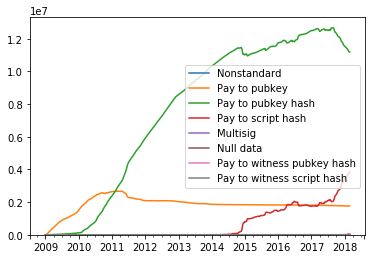

In [7]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot()
ax.set_ylim(ymin=0)

# Feature Analysis

We can pull out different features of transactions or addresses that may flag a certain kind of activity
Taken together, features can be used to find transaction patterns
This section shows a couple simple examples

__Number of transaction inputs and outputs__

This is an example looking at transactions that involve a certain number of addresses. For example, if one address is sending money to many addresses. In the example below, there were over 5000 transactions where more than 100 BTC was sent from a single address to 20+ addresses

In [13]:
# example - one address sent money to a  lot of addresses
%time example_tx = chain.cpp.filter_tx("tx.outputCount() > 20 && tx.inputCount()==1", 0, 510000)




CPU times: user 16.1 s, sys: 192 ms, total: 16.2 s
Wall time: 16.8 s


In [16]:
len(example_tx)

1314983

In [32]:
%time hist, bin_edges = np.histogram([t.input_value/1e8 for t in example_tx],50,(0,100))


CPU times: user 1 s, sys: 28 ms, total: 1.03 s
Wall time: 1.03 s


In [34]:
hist

array([611690, 104795,  60518,  38407,  32575,  25462,  22284,  18732,
        16094,  15575,  15356,  14443,  28861,   8699,   8544,   8639,
         7346,   7351,   6961,   6691,   6890,   6376,   6319,   6340,
         6508,  16463,   3481,   3463,   3323,   3302,   3261,   2907,
         3011,   2714,   2705,   2793,   2499,   2716,   2302,   2302,
         2293,   2169,   2063,   1923,   1984,   1989,   1769,   1788,
         1821,   5134])

Text(0.5,1,'Counts of transactions with 20 inputs, 1 output')

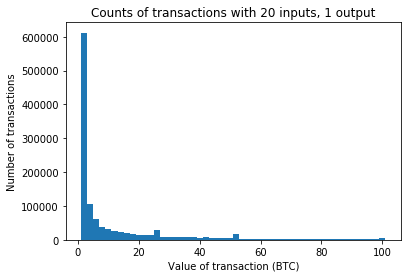

In [35]:
plt.bar(bin_edges[1:],hist,(bin_edges[1]-bin_edges[0]))
plt.xlabel('Value of transaction (BTC)')
plt.ylabel('Number of transactions')
plt.title('Counts of transactions with 20 outputs, 1 input')

__Addresses involved in transactions two blocks in a row__

Time between transactions on an address is an example feature that might give information on how the address is being used
The code below looks through all blocks and counts the number of addresses that appeared in two adjacent blocks
In mid 2015, there was an attach on the bitcoin network (see https://en.bitcoin.it/wiki/July_2015_flood_attack ), possibly this is the spike

In [8]:
cstart = 1
cend = 510000
doubles = [len(set(n.outputs.address).intersection(n_1.outputs.address)) for n,n_1 in zip(chain[cstart:cend],chain[(cstart-1):(cend-1)])]

Text(0.5,1,'Addresses in consecutive transactions')

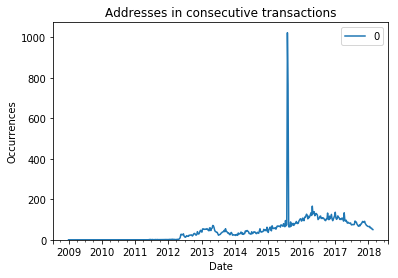

In [12]:
df2 = pd.DataFrame(doubles).fillna(0)
df2 = chain.heights_to_dates(df2)
#df = df.rename(columns={t:str(t) for t in df.columns})
ax = df2.resample("W").mean().plot()
ax.set_ylim(ymin=0)
plt.xlabel('Date')
plt.ylabel('Occurrences')
plt.title('Addresses in consecutive transactions')